In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import datetime

def get_working_dir():
    return Path.cwd()

# Create plots directory for this analysis.
results_dir = get_working_dir() / 'plots' / 'mist'
results_dir.mkdir(parents=True, exist_ok=True)

# ----- Load and Merge Demographics Data -----
# Load demographics files.
df_t_dem  = pd.read_csv(get_working_dir() / 'data' / 'processed' / 't_demographics.csv', encoding='utf-8')
df_m_dem  = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_demographics.csv', encoding='utf-8')
df_mt_dem = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_t_demographics.csv', encoding='utf-8')
df_dem = pd.concat([df_t_dem, df_m_dem, df_mt_dem], ignore_index=True)

# Ensure string type and strip whitespace for selected columns.
for col in ['age_group', 'political_orientation', 'engagement_with_political_content', 'education_level']:
    df_dem[col] = df_dem[col].astype(str).str.strip()

# Filter out "I prefer not to answer" responses for select variables.
for var in ['age_group', 'political_orientation', 'engagement_with_political_content']:
    df_dem = df_dem[df_dem[var] != "I prefer not to answer"]

# ----- Load Claims Data and Compute Veracity Metric (v) -----
def compute_v_metric(df):
    # Assumes columns starting with "claim_" are arranged so that the first 4 are fake items and the next 4 are real items.
    claim_cols = [col for col in df.columns if col.startswith("claim_")]
    fake_cols = claim_cols[:4]
    real_cols = claim_cols[4:8]
    f_score = df[fake_cols].apply(lambda row: sum(1 for x in row 
                                                  if isinstance(x, str) and x.strip().lower() == "fake news"), axis=1)
    r_score = df[real_cols].apply(lambda row: sum(1 for x in row 
                                                  if isinstance(x, str) and x.strip().lower() == "real news"), axis=1)
    return f_score + r_score

df_t_claims  = pd.read_csv(get_working_dir() / 'data' / 'processed' / 't_claims.csv', encoding='utf-8')
df_m_claims  = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_claims.csv', encoding='utf-8')
df_mt_claims = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_t_claims.csv', encoding='utf-8')

df_t_claims['v']  = compute_v_metric(df_t_claims)
df_m_claims['v']  = compute_v_metric(df_m_claims)
df_mt_claims['v'] = compute_v_metric(df_mt_claims)

df_claims = pd.concat([
    df_t_claims[['prolific_id', 'v']],
    df_m_claims[['prolific_id', 'v']],
    df_mt_claims[['prolific_id', 'v']]
], ignore_index=True)

# Merge the claims data with demographics on prolific_id.
df_merged = pd.merge(df_claims, df_dem, on="prolific_id", how="inner")

# ----- Prepare Categorical Variables -----
# Define the desired orders.
pol_order = ["Very Liberal", "Moderately Liberal", "Moderate", "Moderately Conservative", "Very Conservative"]
edu_order = ["Elementary education", "High school diploma or equivalent", "Bachelor's degree", "Master's degree", "Doctoral degree (PhD)"]

df_merged['political_orientation'] = pd.Categorical(df_merged['political_orientation'], categories=pol_order, ordered=True)
df_merged['education_level'] = pd.Categorical(df_merged['education_level'], categories=edu_order, ordered=True)

# ----- Step 1: Compute Subgroup Summary Statistics for v -----
subgroup_stats = df_merged.groupby(['political_orientation', 'education_level'])['v'] \
                          .agg(['mean', 'std', 'count']).reset_index()
subgroup_stats['sem'] = subgroup_stats['std'] / np.sqrt(subgroup_stats['count'])
print("Veracity discernment (v) by Political Orientation and Education Level:")
print(subgroup_stats)

# ----- Step 2: Visualize the Data with a Bar Plot -----
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create a bar plot with political_orientation on x and education_level as the hue.
ax = sns.barplot(data=df_merged, x="political_orientation", y="v", hue="education_level", 
                 order=pol_order, hue_order=edu_order, ci="sd")
ax.set_xlabel("Political Orientation")
ax.set_ylabel("Mean Veracity Discernment (v)")
ax.set_title("Mean Veracity Discernment by Political Orientation and Education Level")

# Optionally, abbreviate education level labels for the legend.
edu_abbr = {"Elementary education": "Elem", "High school diploma or equivalent": "HS", "Bachelor's degree": "BA", "Master's degree": "MA", "Doctoral degree (PhD)": "PhD"}
new_labels = [edu_abbr.get(label.get_text(), label.get_text()) for label in ax.get_legend().get_texts()]
for text, new in zip(ax.get_legend().get_texts(), new_labels):
    text.set_text(new)
ax.legend(title="Education Level", loc="upper right")

plt.tight_layout()
plt.savefig(results_dir / "v_by_pol_and_edu.png")
plt.close()


Veracity discernment (v) by Political Orientation and Education Level:
      political_orientation                    education_level      mean  \
0              Very Liberal               Elementary education       NaN   
1              Very Liberal  High school diploma or equivalent  7.200000   
2              Very Liberal                  Bachelor's degree  7.043478   
3              Very Liberal                    Master's degree  6.333333   
4              Very Liberal              Doctoral degree (PhD)  6.000000   
5        Moderately Liberal               Elementary education       NaN   
6        Moderately Liberal  High school diploma or equivalent  6.178571   
7        Moderately Liberal                  Bachelor's degree  6.575000   
8        Moderately Liberal                    Master's degree  7.200000   
9        Moderately Liberal              Doctoral degree (PhD)  7.000000   
10                 Moderate               Elementary education       NaN   
11               

/var/folders/fv/vf3sjpn92ql19dv_1bf4dl1m0000gn/T/ipykernel_39984/3355068389.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subgroup_stats = df_merged.groupby(['political_orientation', 'education_level'])['v'] \
/var/folders/fv/vf3sjpn92ql19dv_1bf4dl1m0000gn/T/ipykernel_39984/3355068389.py:79: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(data=df_merged, x="political_orientation", y="v", hue="education_level",


In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

def get_working_dir():
    return Path.cwd()

# ---------------------------
# 1. Load and Aggregate Claims Data
# ---------------------------
# Load each file from the 'data/processed' directory.
df_t_claims  = pd.read_csv(get_working_dir() / 'data' / 'processed' / 't_claims.csv', encoding='utf-8', dtype={'prolific_id': str})
df_m_claims  = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_claims.csv', encoding='utf-8', dtype={'prolific_id': str})
df_mt_claims = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_t_claims.csv', encoding='utf-8', dtype={'prolific_id': str})

# Concatenate all data frames.
df_claims = pd.concat([df_t_claims, df_m_claims, df_mt_claims], ignore_index=True)
print("Combined claims data shape:", df_claims.shape)
print("Head of combined claims data:")
print(df_claims.head())

# ---------------------------
# 2. Identify MIST-8 Item Columns and Score Them
# ---------------------------
# Fetch all columns starting with "claim_"
claim_cols = [col for col in df_claims.columns if col.startswith("claim_")]

# Assuming the first four are fake items and the next four are real items.
fake_cols = claim_cols[:4]
real_cols = claim_cols[4:8]

print("\nFake item columns:", fake_cols)
print("Real item columns:", real_cols)

# Define a scoring function: for fake items, 1 if response is "fake news"; for real items, 1 if response is "real news".
def score_item(response, correct_answer):
    if isinstance(response, str) and response.strip().lower() == correct_answer:
        return 1
    else:
        return 0

# Build a new DataFrame X with the 8 binary scores.
X = pd.DataFrame(index=df_claims.index)
for col in fake_cols:
    X[col] = df_claims[col].apply(lambda x: score_item(x, "fake news"))
for col in real_cols:
    X[col] = df_claims[col].apply(lambda x: score_item(x, "real news"))

print("\nFirst 5 rows of binary scored MIST-8 items:")
print(X.head())
print("\nDescriptive statistics for each item:")
print(X.describe())

# ---------------------------
# 3. Compute McDonald’s Omega
# ---------------------------
# Step 1: Compute the correlation (or covariance) matrix of the 8 items.
R = X.corr()
print("\nItem correlation matrix (R):")
print(R)

# Step 2: Perform eigenvalue decomposition of the correlation matrix.
eigenvalues, eigenvectors = np.linalg.eig(R)
print("\nEigenvalues of R:")
print(eigenvalues)

# Identify the largest eigenvalue and corresponding eigenvector.
i_max = np.argmax(eigenvalues.real)
r1 = eigenvalues.real[i_max]
v1 = eigenvectors[:, i_max].real
print(f"\nDominant eigenvalue (r1): {r1}")
print("Corresponding eigenvector (v1):")
print(v1)

# Step 3: Estimate factor loadings.
lambda_vec = np.sqrt(r1) * v1
print("\nEstimated factor loadings (lambda_vec):")
print(lambda_vec)

# Compute unique variances (psi_i = 1 - lambda_i^2 for standardized items).
unique_variances = 1 - lambda_vec**2
print("\nUnique variances for items (psi_i):")
print(unique_variances)

# Total common variance is the square of the sum of loadings.
common_variance = (lambda_vec.sum())**2
# Total variance = common variance + sum of unique variances.
total_variance = common_variance + unique_variances.sum()
# McDonald's Omega
omega_total = common_variance / total_variance

print(f"\nMcDonald's Omega for the aggregated MIST-8 scale: {omega_total:.3f}")

# ---------------------------
# 4. Alternative Omega Calculation (Optional)
# ---------------------------
# Using an alternative formula that uses the number of items (k).
k = X.shape[1]
omega_alternative = (lambda_vec.sum()**2) / ((lambda_vec.sum()**2) + (k - (lambda_vec**2).sum()))
print(f"McDonald's Omega (alternative formula) for the aggregated MIST-8 scale: {omega_alternative:.3f}")


Combined claims data shape: (313, 9)
Head of combined claims data:
                prolific_id claim_stock_manipulation  \
0  629e633c82ed7bd84fce0f9a                Real News   
1  67397a0b8d032875bc9d2568                Real News   
2  66747a68ffbb5cc37d6d2773                Real News   
3  67bcde01b6f0825581d5a80a                Fake News   
4  673ad20cb2afb73a1398a00f                Fake News   

  claim_left_wing_salary_lie claim_vaccine_toxins  \
0                  Fake News            Fake News   
1                  Fake News            Fake News   
2                  Fake News            Real News   
3                  Fake News            Real News   
4                  Real News            Real News   

  claim_government_disease_spread claim_eu_positive_attitudes  \
0                       Fake News                   Real News   
1                       Real News                   Fake News   
2                       Fake News                   Fake News   
3                

In [7]:
import pandas as pd
import numpy as np
from pathlib import Path

def get_working_dir():
    return Path.cwd()

# ---------------------------
# 1. Load and Aggregate Claims Data
# ---------------------------
df_t_claims  = pd.read_csv(get_working_dir() / 'data' / 'processed' / 't_claims.csv',
                            encoding='utf-8', dtype={'prolific_id': str})
df_m_claims  = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_claims.csv',
                            encoding='utf-8', dtype={'prolific_id': str})
df_mt_claims = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_t_claims.csv',
                            encoding='utf-8', dtype={'prolific_id': str})

# Concatenate all three files.
df_claims = pd.concat([df_t_claims, df_m_claims, df_mt_claims], ignore_index=True)
print("Combined claims data shape:", df_claims.shape)
print("Head of combined claims data:")
print(df_claims.head())

# ---------------------------
# 2. Identify MIST-8 Items and Prepare Scoring
# ---------------------------
# Get the first 8 columns that start with "claim_" (assuming there are at least 8).
claim_cols = [col for col in df_claims.columns if col.startswith("claim_")][:8]
print("\nMIST-8 item columns used for scoring:")
print(claim_cols)

# Define scoring functions for each response.
def score_fake(response):
    # Returns 1 if the response is "fake news" (ignoring whitespace and case), else 0.
    if isinstance(response, str) and response.strip().lower() == "fake news":
        return 1
    else:
        return 0

def score_real(response):
    # Returns 1 if the response is "real news" (ignoring whitespace and case), else 0.
    if isinstance(response, str) and response.strip().lower() == "real news":
        return 1
    else:
        return 0

# ---------------------------
# 3. Calculate Distrust (d) and Naïvité (n)
# ---------------------------
# For each participant, count the number of "fake news" responses among the 8 items.
df_claims['fake_count'] = df_claims[claim_cols].apply(lambda row: sum(score_fake(x) for x in row), axis=1)
# Similarly, count "real news" responses.
df_claims['real_count'] = df_claims[claim_cols].apply(lambda row: sum(score_real(x) for x in row), axis=1)

# Now, for MIST-8, subtract 4 from each count and floor negative values to zero.
df_claims['d'] = (df_claims['fake_count'] - 4).clip(lower=0)
df_claims['n'] = (df_claims['real_count'] - 4).clip(lower=0)

# ---------------------------
# 4. Debug Output: Check the Calculation for a Few Cases
# ---------------------------
print("\nFirst 5 rows of raw counts and computed distrust (d) and naïvité (n):")
print(df_claims[['prolific_id', 'fake_count', 'real_count', 'd', 'n']].head())

print("\nDescriptive statistics for Distrust (d):")
print(df_claims['d'].describe())

print("\nDescriptive statistics for Naïvité (n):")
print(df_claims['n'].describe())

# ---------------------------
# 5. (Optional) Save the Results for Further Analysis
# ---------------------------
results_dir = get_working_dir() / 'plots' / 'mist'
results_dir.mkdir(parents=True, exist_ok=True)
df_claims.to_csv(results_dir / "mist8_distrust_naivite.csv", index=False)

Combined claims data shape: (313, 9)
Head of combined claims data:
                prolific_id claim_stock_manipulation  \
0  629e633c82ed7bd84fce0f9a                Real News   
1  67397a0b8d032875bc9d2568                Real News   
2  66747a68ffbb5cc37d6d2773                Real News   
3  67bcde01b6f0825581d5a80a                Fake News   
4  673ad20cb2afb73a1398a00f                Fake News   

  claim_left_wing_salary_lie claim_vaccine_toxins  \
0                  Fake News            Fake News   
1                  Fake News            Fake News   
2                  Fake News            Real News   
3                  Fake News            Real News   
4                  Real News            Real News   

  claim_government_disease_spread claim_eu_positive_attitudes  \
0                       Fake News                   Real News   
1                       Real News                   Fake News   
2                       Fake News                   Fake News   
3                

Loaded aggregated MIST-8 results (first 5 rows):
                prolific_id claim_stock_manipulation  \
0  629e633c82ed7bd84fce0f9a                Real News   
1  67397a0b8d032875bc9d2568                Real News   
2  66747a68ffbb5cc37d6d2773                Real News   
3  67bcde01b6f0825581d5a80a                Fake News   
4  673ad20cb2afb73a1398a00f                Fake News   

  claim_left_wing_salary_lie claim_vaccine_toxins  \
0                  Fake News            Fake News   
1                  Fake News            Fake News   
2                  Fake News            Real News   
3                  Fake News            Real News   
4                  Real News            Real News   

  claim_government_disease_spread claim_eu_positive_attitudes  \
0                       Fake News                   Real News   
1                       Real News                   Fake News   
2                       Fake News                   Fake News   
3                       Fake News  

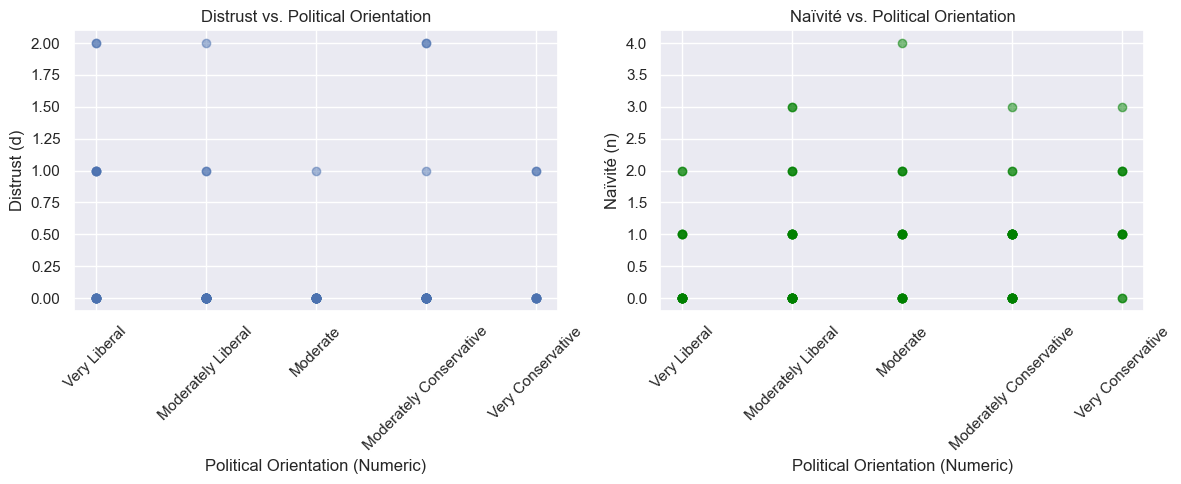

In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import spearmanr, kendalltau
import matplotlib.pyplot as plt

def get_working_dir():
    return Path.cwd()

# ---------------------------
# 1. Load the Aggregated MIST-8 Results
# ---------------------------
# This file should have the computed distrust (d) and naïvité (n) scores.
results_file = get_working_dir() / 'plots' / 'mist' / 'mist8_distrust_naivite.csv'
df = pd.read_csv(results_file, encoding='utf-8')
print("Loaded aggregated MIST-8 plots (first 5 rows):")
print(df.head())

# ---------------------------
# 2. Ensure Political Orientation is Present
# ---------------------------
# If the political_orientation column is not present in the plots file,
# we merge it with a demographics file.
if 'political_orientation' not in df.columns:
    print("\nPolitical orientation column not found. Merging with a demographics file...")
    # Adjust the file name if needed (here we use t_demographics.csv as an example)
    demo_file = get_working_dir() / 'data' / 'processed' / 't_demographics.csv'
    df_demo = pd.read_csv(demo_file, encoding='utf-8', dtype={'prolific_id': str})
    # Filter out "I prefer not to answer" responses
    df_demo = df_demo[df_demo['political_orientation'] != "I prefer not to answer"]
    # Keep only the relevant columns
    df = pd.merge(df, df_demo[['prolific_id', 'political_orientation']], on='prolific_id', how='left')

print("\nData after ensuring political_orientation (first 5 rows):")
print(df[['prolific_id', 'political_orientation', 'd', 'n']].head())

# ---------------------------
# 3. Map Political Orientation to a Numeric Ordinal Scale
# ---------------------------
# We assume a five-category scale:
# Very Liberal = 1, Moderately Liberal = 2, Moderate = 3, Moderately Conservative = 4, Very Conservative = 5
orientation_mapping = {
    "Very Liberal": 1,
    "Moderately Liberal": 2,
    "Moderate": 3,
    "Moderately Conservative": 4,
    "Very Conservative": 5
}

df['pol_numeric'] = df['political_orientation'].map(orientation_mapping)

# Drop rows with missing political orientation or scores.
df_clean = df.dropna(subset=['pol_numeric', 'd', 'n'])
print("\nCleaned data (first 5 rows):")
print(df_clean[['prolific_id', 'political_orientation', 'pol_numeric', 'd', 'n']].head())

# ---------------------------
# 4. Calculate Correlations
# ---------------------------
# Using Spearman's rho (non-parametric, good for ordinal data)
rho_d, p_d = spearmanr(df_clean['pol_numeric'], df_clean['d'])
rho_n, p_n = spearmanr(df_clean['pol_numeric'], df_clean['n'])

print("\nSpearman correlation between Political Orientation and Distrust (d):")
print(f"rho = {rho_d:.3f}, p = {p_d:.3e}")

print("\nSpearman correlation between Political Orientation and Naïvité (n):")
print(f"rho = {rho_n:.3f}, p = {p_n:.3e}")

# As an alternative, you can also compute Kendall's tau:
tau_d, p_tau_d = kendalltau(df_clean['pol_numeric'], df_clean['d'])
tau_n, p_tau_n = kendalltau(df_clean['pol_numeric'], df_clean['n'])

print("\nKendall tau correlation between Political Orientation and Distrust (d):")
print(f"tau = {tau_d:.3f}, p = {p_tau_d:.3e}")

print("\nKendall tau correlation between Political Orientation and Naïvité (n):")
print(f"tau = {tau_n:.3f}, p = {p_tau_n:.3e}")

# ---------------------------
# 5. (Optional) Visualization
# ---------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(df_clean['pol_numeric'], df_clean['d'], alpha=0.5)
plt.xlabel("Political Orientation (Numeric)")
plt.ylabel("Distrust (d)")
plt.title("Distrust vs. Political Orientation")
plt.xticks(list(orientation_mapping.values()), list(orientation_mapping.keys()), rotation=45)

plt.subplot(1, 2, 2)
plt.scatter(df_clean['pol_numeric'], df_clean['n'], color='green', alpha=0.5)
plt.xlabel("Political Orientation (Numeric)")
plt.ylabel("Naïvité (n)")
plt.title("Naïvité vs. Political Orientation")
plt.xticks(list(orientation_mapping.values()), list(orientation_mapping.keys()), rotation=45)

plt.tight_layout()
plt.show()


In [11]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import f_oneway
import matplotlib.pyplot as plt

def get_working_dir():
    return Path.cwd()

# ---------------------------
# 1. Load the Aggregated MIST-8 Results
# ---------------------------
results_file = get_working_dir() / 'plots' / 'mist' / 'mist8_distrust_naivite.csv'
df_results = pd.read_csv(results_file, encoding='utf-8')
print("Loaded aggregated MIST-8 plots (first 5 rows):")
print(df_results.head())

# ---------------------------
# 2. Load and Aggregate Demographics Data from All Three Files
# ---------------------------
df_t_dem = pd.read_csv(get_working_dir() / 'data' / 'processed' / 't_demographics.csv',
                       encoding='utf-8', dtype={'prolific_id': str})
df_m_dem = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_demographics.csv',
                       encoding='utf-8', dtype={'prolific_id': str})
df_mt_dem = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_t_demographics.csv',
                        encoding='utf-8', dtype={'prolific_id': str})

# Concatenate the three demographics DataFrames.
df_demo = pd.concat([df_t_dem, df_m_dem, df_mt_dem], ignore_index=True)
print("\nCombined demographics data (first 5 rows):")
print(df_demo[['prolific_id','political_orientation']].head())

# Filter out responses that are "I prefer not to answer".
df_demo = df_demo[df_demo['political_orientation'] != "I prefer not to answer"]
df_demo = df_demo.dropna(subset=["political_orientation"])
print("\nAggregated political_orientation value counts:")
print(df_demo['political_orientation'].value_counts())

# ---------------------------
# 3. Merge Aggregated Results with Demographics
# ---------------------------
# Merge on 'prolific_id'
df_merged = pd.merge(df_results, df_demo[['prolific_id', 'political_orientation']], 
                     on='prolific_id', how='inner')
print("\nMerged dataset (first 5 rows):")
print(df_merged[['prolific_id', 'political_orientation', 'd', 'n']].head())

# ---------------------------
# 4. Map Political Orientation into Three Groups
# ---------------------------
def map_to_three_groups(x):
    x = x.strip()
    if x in ["Very Liberal", "Moderately Liberal"]:
        return "Liberal"
    elif x == "Moderate":
        return "Moderate"
    elif x in ["Moderately Conservative", "Very Conservative"]:
        return "Conservative"
    else:
        return np.nan

df_merged["pol_group_3"] = df_merged["political_orientation"].apply(map_to_three_groups)
df_merged = df_merged.dropna(subset=["pol_group_3", "d", "n"])
print("\nPolitical group (three-group) counts:")
print(df_merged["pol_group_3"].value_counts())

# ---------------------------
# 5. Compute Descriptive Statistics and One-Way ANOVA for Distrust (d) and Naïvité (n)
# ---------------------------
grouped_stats = df_merged.groupby("pol_group_3")[["d", "n"]].describe()
print("\nDescriptive statistics for Distrust (d) and Naïvité (n) by Political Group:")
print(grouped_stats)

# One-way ANOVA for Distrust (d)
groups_d = [group["d"].values for name, group in df_merged.groupby("pol_group_3")]
anova_d = f_oneway(*groups_d)
print("\nOne-way ANOVA for Distrust (d) across groups:")
print(f"F = {anova_d.statistic:.3f}, p = {anova_d.pvalue:.3e}")

# One-way ANOVA for Naïvité (n)
groups_n = [group["n"].values for name, group in df_merged.groupby("pol_group_3")]
anova_n = f_oneway(*groups_n)
print("\nOne-way ANOVA for Naïvité (n) across groups:")
print(f"F = {anova_n.statistic:.3f}, p = {anova_n.pvalue:.3e}")

# # ---------------------------
# # 6. (Optional) Visualization
# # ---------------------------
# fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# 
# # Bar plot for Distrust (d)
# mean_d = df_merged.groupby("pol_group_3")["d"].mean()
# std_d = df_merged.groupby("pol_group_3")["d"].std()
# mean_d.plot(kind="bar", ax=axs[0], yerr=std_d, capsize=5)
# axs[0].set_title("Mean Distrust (d) by Political Group")
# axs[0].set_xlabel("Political Group")
# axs[0].set_ylabel("Mean Distrust (d)")
# 
# # Bar plot for Naïvité (n)
# mean_n = df_merged.groupby("pol_group_3")["n"].mean()
# std_n = df_merged.groupby("pol_group_3")["n"].std()
# mean_n.plot(kind="bar", ax=axs[1], yerr=std_n, capsize=5, color="orange")
# axs[1].set_title("Mean Naïvité (n) by Political Group")
# axs[1].set_xlabel("Political Group")
# axs[1].set_ylabel("Mean Naïvité (n)")
# 
# plt.tight_layout()
# plt.show()


Loaded aggregated MIST-8 results (first 5 rows):
                prolific_id claim_stock_manipulation  \
0  629e633c82ed7bd84fce0f9a                Real News   
1  67397a0b8d032875bc9d2568                Real News   
2  66747a68ffbb5cc37d6d2773                Real News   
3  67bcde01b6f0825581d5a80a                Fake News   
4  673ad20cb2afb73a1398a00f                Fake News   

  claim_left_wing_salary_lie claim_vaccine_toxins  \
0                  Fake News            Fake News   
1                  Fake News            Fake News   
2                  Fake News            Real News   
3                  Fake News            Real News   
4                  Real News            Real News   

  claim_government_disease_spread claim_eu_positive_attitudes  \
0                       Fake News                   Real News   
1                       Real News                   Fake News   
2                       Fake News                   Fake News   
3                       Fake News  

In [12]:
import pandas as pd
from pathlib import Path

def get_working_dir():
    return Path.cwd()

# Load demographics files from the processed data folder.
df_t_dem = pd.read_csv(get_working_dir() / 'data' / 'processed' / 't_demographics.csv',
                       encoding='utf-8', dtype={'prolific_id': str})
df_m_dem = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_demographics.csv',
                       encoding='utf-8', dtype={'prolific_id': str})
df_mt_dem = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_t_demographics.csv',
                        encoding='utf-8', dtype={'prolific_id': str})

# Concatenate all three demographics DataFrames.
df_demo = pd.concat([df_t_dem, df_m_dem, df_mt_dem], ignore_index=True)

# Optionally, you can strip extra whitespace if needed.
df_demo['political_orientation'] = df_demo['political_orientation'].astype(str).str.strip()

# Print the frequency counts for each label in the political_orientation column.
print("Counts of participants per political orientation label:")
print(df_demo['political_orientation'].value_counts())


Counts of participants per political orientation label:
political_orientation
Moderately Conservative    86
Moderately Liberal         81
Moderate                   61
Very Liberal               54
Very Conservative          27
I prefer not to answer      4
Name: count, dtype: int64


In [16]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import pearsonr

def get_working_dir():
    return Path.cwd()

# Mapping for accuracy responses.
accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

# Mapping for correction explainability responses.
explainability_mapping = {
    "Not at all well conveyed": 1,
    "Slightly well conveyed": 2,
    "Moderately well conveyed": 3,
    "Very well conveyed": 4,
    "Extremely well conveyed": 5
}

# Compute overall belief change for all 10 claims.
def compute_overall_belief_change(df):
    changes = []
    for i in range(1, 11):
        pre_col  = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        # Map textual responses if needed.
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(accuracy_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(accuracy_mapping)
        # Compute the difference if both columns exist.
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    # Return the average difference across claims.
    return pd.concat(changes, axis=1).mean(axis=1) if changes else pd.Series(np.nan, index=df.index)

# Compute overall explainability for all 10 claims.
def compute_explainability_mean(df):
    scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_explainability"
        if col in df.columns:
            # Map textual responses if needed.
            if df[col].dtype == object:
                df[col] = df[col].str.strip().map(explainability_mapping)
            scores.append(df[col])
    return pd.concat(scores, axis=1).mean(axis=1) if scores else pd.Series(np.nan, index=df.index)

# Process a single phase file: compute metrics and add an explanation type label.
def process_phase_file(file_name, expl_type_label):
    path = get_working_dir() / 'data' / 'processed' / file_name
    df = pd.read_csv(path, encoding='utf-8', dtype={'prolific_id': str})
    df["overall_belief_change"] = compute_overall_belief_change(df)
    df["explainability_mean"] = compute_explainability_mean(df)
    df["expl_type"] = expl_type_label
    return df[['prolific_id', 'overall_belief_change', 'explainability_mean', 'expl_type']].dropna()

# List of phase files (one per explanation type) with their labels.
phase_files = [
    ("t_phase6.csv", "Text"),
    ("m_phase7.csv", "Meme"),
    ("m_t_phase6.csv", "Meme+Context")
]

# Process each file and combine the plots.
dfs = []
for file_name, label in phase_files:
    dfs.append(process_phase_file(file_name, label))
df_combined = pd.concat(dfs, ignore_index=True)

# For each explanation type, compute the Pearson correlation between overall belief change and explainability.
for expl in df_combined["expl_type"].unique():
    subset = df_combined[df_combined["expl_type"] == expl]
    r, p = pearsonr(subset["overall_belief_change"], subset["explainability_mean"])
    print(f"Explanation Type: {expl}")
    print(f"Pearson correlation between overall belief change and explainability: r = {r:.3f}, p = {p:.3e}\n")


Explanation Type: Text
Pearson correlation between overall belief change and explainability: r = 0.056, p = 5.617e-01

Explanation Type: Meme
Pearson correlation between overall belief change and explainability: r = 0.303, p = 2.060e-03

Explanation Type: Meme+Context
Pearson correlation between overall belief change and explainability: r = 0.037, p = 7.103e-01



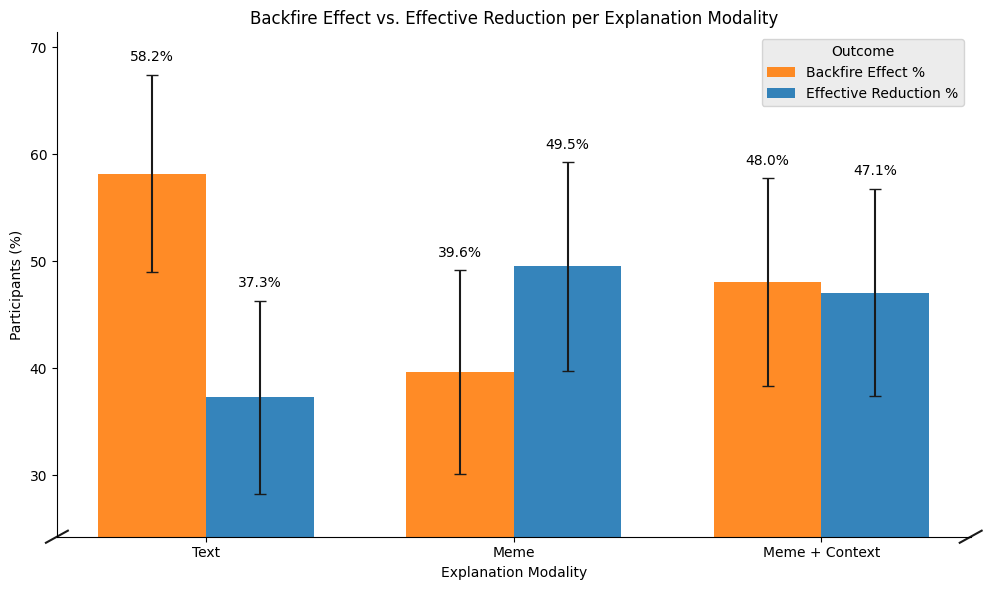

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
import pandas.api.types as ptypes

df_t = pd.read_csv(get_working_dir() / 'data' / 'processed' / 't_phase6.csv', encoding='utf-8')
df_m = pd.read_csv(get_working_dir() /  'data' / 'processed' / 'm_phase7.csv', encoding='utf-8')
df_m_t = pd.read_csv(get_working_dir() /  'data' / 'processed' / 'm_t_phase6.csv', encoding='utf-8')

accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

confidence_mapping = {
    "Not at all confident": 1,
    "Slightly confident": 2,
    "Moderately confident": 3,
    "Very confident": 4,
    "Extremely confident": 5
}

engagement_mapping = {
    "Very unlikely": 1,
    "Somewhat unlikely": 2,
    "Neither likely nor unlikely": 3,
    "Somewhat likely": 4,
    "Very likely": 5
}

explainability_mapping = {
    "Not at all well conveyed": 1,
    "Slightly well conveyed": 2,
    "Moderately well conveyed": 3,
    "Very well conveyed": 4,
    "Extremely well conveyed": 5
}

credibility_mapping = {
    "Not at all credible": 1,
    "Slightly credible": 2,
    "Moderately credible": 3,
    "Very credible": 4,
    "Extremely credible": 5
}

def convert_likert_values(df):
    for col in df.columns:
        # Only process columns with string type.
        if ptypes.is_string_dtype(df[col]):
            if "accuracy" in col:
                df[col] = df[col].str.strip().map(accuracy_mapping)
            elif "confidence" in col:
                df[col] = df[col].str.strip().map(confidence_mapping)
            elif "engagement" in col:
                df[col] = df[col].str.strip().map(engagement_mapping)
            elif "explainability" in col:
                df[col] = df[col].str.strip().map(explainability_mapping)
            elif "credibility" in col:
                df[col] = df[col].str.strip().map(credibility_mapping)
    return df

df_t   = convert_likert_values(df_t)
df_m   = convert_likert_values(df_m)
df_m_t = convert_likert_values(df_m_t)

def compute_accuracy_change(df):
    """Return a Series with each participant’s mean (post-pre) accuracy change."""
    diff_cols = []
    for i in range(1, 11):                              # claim1 … claim10
        pre, post = f"claim{i}_pre_accuracy", f"claim{i}_post_accuracy"
        if pre in df.columns and post in df.columns:
            diff = f"claim{i}_acc_change"
            df[diff] = df[post] - df[pre]
            diff_cols.append(diff)
    df["mean_acc_change"] = df[diff_cols].mean(axis=1)
    return df["mean_acc_change"]

def summarise(series, label):
    """Back-fire / effective-reduction proportions + 95 % CI (Wald)."""
    s = series.dropna()
    n = len(s)
    # proportions
    p_back  = (s > 0).mean()
    p_reduce = (s < 0).mean()
    # Wald 95 % CI
    se_back  = np.sqrt(p_back  * (1 - p_back)  / n)
    se_reduce = np.sqrt(p_reduce * (1 - p_reduce) / n)
    ci_back  = 1.96 * se_back
    ci_reduce = 1.96 * se_reduce
    return {
        "Explanation" : label,
        "Backfire"    : p_back,
        "Backfire_CI" : ci_back,
        "Reduction"   : p_reduce,
        "Reduction_CI": ci_reduce,
    }

# -------------------------------------------------------
# 2.  Build the summary table ---------------------------
#    (assumes df_t, df_m, df_m_t already exist)
# -------------------------------------------------------
text_change   = compute_accuracy_change(df_t)
meme_change   = compute_accuracy_change(df_m)
memeCt_change = compute_accuracy_change(df_m_t)

summary = pd.DataFrame([
    summarise(text_change,   "Text"),
    summarise(meme_change,   "Meme"),
    summarise(memeCt_change, "Meme + Context")
])

# --------- assume `summary` already contains Backfire, Reduction, CIs ----------
x         = np.arange(len(summary))
bar_width = 0.35

# swap colours:  orange  →  back-fire        blue  →  reduction
COL_BACK  = "#ff7f0e"      # orange
COL_REDUC = "#1f77b4"      # blue

back_means = summary["Backfire"].values   * 100
back_errs  = summary["Backfire_CI"].values * 100
red_means  = summary["Reduction"].values  * 100
red_errs   = summary["Reduction_CI"].values * 100

plt.style.use("default")                  # white background, no seaborn grid
fig, ax = plt.subplots(figsize=(10, 6))

bars_back = ax.bar(x - bar_width/2, back_means, width=bar_width,
                   yerr=back_errs, capsize=4,
                   label="Backfire Effect %",        color=COL_BACK,  alpha=0.9)
bars_red  = ax.bar(x + bar_width/2, red_means,  width=bar_width,
                   yerr=red_errs,  capsize=4,
                   label="Effective Reduction %", color=COL_REDUC, alpha=0.9)

# ---- value labels above each bar --------------------------------------------
def add_labels(bars, errs):
    for bar, err in zip(bars, errs):
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + err + 1,
                f"{h:.1f}%", ha="center", va="bottom", fontsize=10)
add_labels(bars_back, back_errs)
add_labels(bars_red,  red_errs)

# ---- axes, title, legend -----------------------------------------------------
ax.set_xticks(x)
ax.set_xticklabels(summary["Explanation"])
ax.set_xlabel("Explanation Modality")
ax.set_ylabel("Participants (%)")
ax.set_title("Backfire Effect vs. Effective Reduction per Explanation Modality")

# zoom y-axis and add a “cut” mark to show truncation
low  = min(back_means - back_errs).min()
low  = min(low, (red_means - red_errs).min())
high = max(back_means + back_errs).max()
high = max(high, (red_means + red_errs).max())
pad  = 4
ax.set_ylim(low - pad, high + pad)

# draw a diagonally-hatched “cut” on the y-axis
d = .012                                    # size of the diagonal lines
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)       # left bottom
ax.plot((1-d, 1+d), (-d, +d), **kwargs)     # right bottom (optional)

# Tidy spines & legend background colour
ax.grid(False)
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)

leg = ax.legend(title="Outcome", frameon=True)
leg.get_frame().set_facecolor("#e8e8e8")    # soft-grey legend background

fig.patch.set_facecolor("white")
ax.set_facecolor("white")

plt.tight_layout()
plt.savefig("../new_results/backfire_vs_effective.png", dpi=300)
plt.show()
